# Forecasting Bilateral Trade Flow Volume Between Nations

## Description

## Notebook Structure
1. Import Packages
2. Identify target and feature variables; target must be continuous.
3. Seperate X (ind. variables) and y (target variable)
4. Exploratory Data Analysis: 
    a. Descriptive statistics 
    b. Infirential statistics (hypothesis testing)
    c. Check linearity/mulicolinearity (pairplot, df.corr)
5. Data Prep:
    a. Apply scaling to continuous numerical features
    b. Remove outliers (optional)
    c. Normalize (if qq plot shows non-normal residual distribution)
    d. Feature engineering (build new features)
6. Train/Test/Validate Split
7. Model Building (fit and score)
8. Model Evaluation (applying train fit to test data)
9. Model Selection (regularization; lasso, ridge, elastic net)
10. Check remaining assumptions (qq plot, homoscedascity) 
    a. If QQ plot fails, apply box-cox transformation back in step 5(normalize)
    b. If Assumptions fail, check/apply Quantile Regression

### 1. Import Cleaned Data & Packages

In [11]:
%matplotlib inline
import warnings
warnings.filterwarnings(action='ignore')

%load_ext autoreload
%autoreload 2

from scipy import stats

import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [2]:
df = pd.read_pickle('data/trade_data.pkl')

In [3]:
df.head()

,year,shared_border,shared_primary_language,pop_weighted_distance_km,pop_mil_ex,gdp_usd_current_ex,gdp_capita_usd_current_ex,pop_mil_im,gdp_usd_current_im,gdp_capita_usd_current_im,...,regional_trade_agreement,shared_legal_origin,shared_currency,acp_to_eu,gsp_ex,eu_to_acp,gsp_im,trade_flow_usd_mil,country_ex,country_im
0,1999,0,0,9587.315563,NaN,1722.905029,NaN,13.500820,6154.479980,455.859711,...,0,1,0,0,0,0,0,0.0,Aruba,Angola
1,2000,0,0,9587.315563,NaN,1858.659180,NaN,13.840636,9129.179688,659.592468,...,0,1,0,0,0,0,0,0.0,Aruba,Angola
2,2001,0,0,9587.315563,NaN,1898.882690,NaN,14.214834,8936.023438,628.640686,...,0,1,0,0,0,0,0,0.0,Aruba,Angola
3,2002,0,0,9587.315563,NaN,1911.173218,NaN,14.618782,11431.738281,781.989807,...,0,1,0,0,0,0,0,0.0,Aruba,Angola
4,2003,0,0,9587.315563,0.099,NaN,NaN,15.046907,13956.267578,927.517334,...,0,1,0,0,0,0,0,0.0,Aruba,Angola


In [4]:
len(df)

1135895

In [ ]:
### 2. Identify Target and Feature Variables

In [5]:
list(df.columns)

['year',
 'shared_border',
 'shared_primary_language',
 'pop_weighted_distance_km',
 'pop_mil_ex',
 'gdp_usd_current_ex',
 'gdp_capita_usd_current_ex',
 'pop_mil_im',
 'gdp_usd_current_im',
 'gdp_capita_usd_current_im',
 'im_current_former_hegemon_ex',
 'at_war_current',
 'independence_date',
 'ex_current_former_hegemon_im',
 'im_colonyof_ex',
 'ex_colonyof_im',
 'hist_colonial_relationship',
 'current_colonial_relationship',
 'ex_gatt_wto_member',
 'im_gatt_wto_member',
 'regional_trade_agreement',
 'shared_legal_origin',
 'shared_currency',
 'acp_to_eu',
 'gsp_ex',
 'eu_to_acp',
 'gsp_im',
 'trade_flow_usd_mil',
 'country_ex',
 'country_im']

In [6]:
df.describe()

,year,shared_border,shared_primary_language,pop_weighted_distance_km,pop_mil_ex,gdp_usd_current_ex,gdp_capita_usd_current_ex,pop_mil_im,gdp_usd_current_im,gdp_capita_usd_current_im,...,ex_gatt_wto_member,im_gatt_wto_member,regional_trade_agreement,shared_legal_origin,shared_currency,acp_to_eu,gsp_ex,eu_to_acp,gsp_im,trade_flow_usd_mil
count,1.135895e+06,1.135895e+06,1.135895e+06,1.135895e+06,1.070598e+06,9.776190e+05,974499.000000,1.098779e+06,1.028299e+06,1.024426e+06,...,1.135895e+06,1.135895e+06,1.135895e+06,1.135895e+06,1.135895e+06,1.135895e+06,1.135895e+06,1.135895e+06,1.135895e+06,1.135895e+06
mean,1.982317e+03,1.999921e-02,1.850567e-01,7.767444e+03,3.316333e+01,1.381900e+05,4635.567507,3.279660e+01,1.332987e+05,4.511276e+03,...,5.650487e-01,6.043534e-01,2.816986e-02,3.607631e-01,2.017088e-02,2.302590e-02,6.317837e-02,2.250384e-02,6.329194e-02,1.335403e+02
std,1.648193e+01,1.399973e-01,3.883437e-01,4.453237e+03,1.153022e+02,6.529415e+05,8041.683392,1.121094e+02,6.397474e+05,7.933406e+03,...,4.957508e-01,4.889893e-01,1.654580e-01,4.802221e-01,1.405846e-01,1.499857e-01,2.432836e-01,1.483153e-01,2.434874e-01,2.054154e+03
min,1.948000e+03,0.000000e+00,0.000000e+00,6.077057e+01,1.970000e-02,1.159205e+01,6.813283,1.970000e-02,1.159205e+01,6.813283e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.969000e+03,0.000000e+00,0.000000e+00,4.243341e+03,2.075000e+00,1.645918e+03,357.157196,2.482000e+00,1.661019e+03,3.504062e+02,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,1.985000e+03,0.000000e+00,0.000000e+00,7.377837e+03,6.882600e+00,7.381854e+03,1155.947998,7.303875e+00,7.122000e+03,1.118617e+03,...,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.200000e-02
75%,1.997000e+03,0.000000e+00,0.000000e+00,1.077598e+04,2.134993e+01,4.971557e+04,4354.144531,2.211280e+01,4.647922e+04,4.137321e+03,...,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.228730e+00
max,2.006000e+03,1.000000e+00,1.000000e+00,1.978139e+04,1.311798e+03,1.320182e+07,89563.632812,1.311798e+03,1.320182e+07,8.956363e+04,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,3.484206e+05


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1135895 entries, 0 to 1135894
Data columns (total 30 columns):
year                             1135895 non-null int64
shared_border                    1135895 non-null int64
shared_primary_language          1135895 non-null int64
pop_weighted_distance_km         1135895 non-null float64
pop_mil_ex                       1070598 non-null float64
gdp_usd_current_ex               977619 non-null float64
gdp_capita_usd_current_ex        974499 non-null float64
pop_mil_im                       1098779 non-null float64
gdp_usd_current_im               1028299 non-null float64
gdp_capita_usd_current_im        1024426 non-null float64
im_current_former_hegemon_ex     1135895 non-null int64
at_war_current                   18405 non-null float64
independence_date                18405 non-null float64
ex_current_former_hegemon_im     1135895 non-null int64
im_colonyof_ex                   1135895 non-null int64
ex_colonyof_im                   11

In [8]:
df.drop(columns=['at_war_current', 'independence_date'], inplace=True)

In [9]:
df.dropna(inplace=True)

In [10]:
len(df)

898681

In [24]:
from sklearn.preprocessing import StandardScaler

def scale_num(df):
    
    ss = StandardScaler()
    df_stand = pd.DataFrame(ss.fit_transform(df))
    df_stand.set_index(df.index, inplace=True)
    df_stand.columns = df.columns
    df_stand = df_stand[(np.abs(stats.zscore(df_stand)) < 2.5).all(axis=1)]
    
    return df_stand

In [15]:
def statsmodel_ols(X, y):
    
    X = sm.add_constant(X)
    mod = sm.OLS(y, X, hasconst = True)
    res = mod.fit()
    print(res.summary())
    ax = sm.qqplot(res.resid, line = 'r')
    ax.show()

In [16]:
corr = list(df.corr().sort_values('trade_flow_usd_mil').index)
corr

['pop_weighted_distance_km',
 'acp_to_eu',
 'eu_to_acp',
 'shared_legal_origin',
 'current_colonial_relationship',
 'shared_primary_language',
 'gsp_im',
 'gsp_ex',
 'im_current_former_hegemon_ex',
 'ex_colonyof_im',
 'im_colonyof_ex',
 'ex_current_former_hegemon_im',
 'hist_colonial_relationship',
 'shared_currency',
 'ex_gatt_wto_member',
 'im_gatt_wto_member',
 'year',
 'pop_mil_im',
 'pop_mil_ex',
 'shared_border',
 'gdp_capita_usd_current_ex',
 'gdp_capita_usd_current_im',
 'regional_trade_agreement',
 'gdp_usd_current_ex',
 'gdp_usd_current_im',
 'trade_flow_usd_mil']

In [40]:
# Declare feature variable and target variable
X = df.drop(columns=['year', 'trade_flow_usd_mil', 'country_ex', 'country_im', 'hist_colonial_relationship',
                     'current_colonial_relationship', 'ex_colonyof_im', 'im_colonyof_ex', 'im_current_former_hegemon_ex',
                     'ex_current_former_hegemon_im'])
y = df['trade_flow_usd_mil']

In [41]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(718944, 18)
(179737, 18)
(718944,)
(179737,)


In [42]:
numerical_columns = ['pop_weighted_distance_km',
                     'pop_mil_ex',
                     'gdp_usd_current_ex',
                     'gdp_capita_usd_current_ex',
                     'pop_mil_im',
                     'gdp_usd_current_im',
                     'gdp_capita_usd_current_im']

In [43]:
X_train_num = X_train[numerical_columns]
X_train_cat = X_train.drop(columns=numerical_columns)
X_test_num = X_test[numerical_columns]
X_test_cat = X_test.drop(columns=numerical_columns)

In [44]:
X_train_num_stand = scale_num(X_train_num)
X_train_cat = X_train_cat.loc[X_train_num_stand.index]
y_train = y_train.loc[X_train_num_stand.index]
X_train_stand = X_train_cat.join(X_train_num_stand)
print(X_train_stand.shape)
print(y_train.shape)

(625621, 18)
(625621,)


In [45]:
X_test_num_stand = scale_num(X_test_num)
X_test_cat = X_test_cat.loc[X_test_num_stand.index]
y_test = y_test.loc[X_test_num_stand.index]
X_test_stand = X_test_cat.join(X_test_num_stand)
print(X_test_stand.shape)
print(y_test.shape)

(156203, 18)
(156203,)


                            OLS Regression Results                            
Dep. Variable:     trade_flow_usd_mil   R-squared:                       0.156
Model:                            OLS   Adj. R-squared:                  0.156
Method:                 Least Squares   F-statistic:                     6424.
Date:                Fri, 26 Jun 2020   Prob (F-statistic):               0.00
Time:                        11:19:12   Log-Likelihood:            -4.8216e+06
No. Observations:              625621   AIC:                         9.643e+06
Df Residuals:                  625602   BIC:                         9.643e+06
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

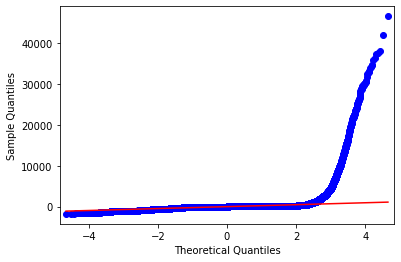

In [48]:
X_train_stand = sm.add_constant(X_train_stand)
mod = sm.OLS(y_train, X_train_stand, hasconst = True)
res = mod.fit()
y_train_pred = res.predict(X_train_stand)
print(res.summary())
ax = sm.qqplot(res.resid, line = 'r')
ax.show()

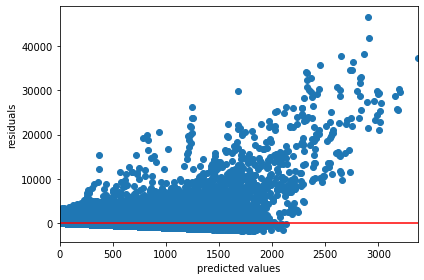

In [49]:
plt.scatter(y_train_pred, res.resid)
plt.axhline(y=0, color = 'red', label = '0')
plt.xlabel('predicted values')
plt.ylabel('residuals')
plt.xlim(0, y_train_pred.max())
plt.tight_layout()